# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 10. Анализ вакансий.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb` и полученные данные** (подробности далее). Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Будьте внимательны при работе со сбором данных. Ответственность за корректность ваших действий лежит на вас. Не нагружайте сервера, *делайте паузы между запросами*. Как следствие, начинайте выполнять задание заранее. **Если вас где-то забаннили и т.п., то это не является уважительной причиной продления дедлайна.**
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


---

**Баллы за задание:**

<b><a href="#Сложная-часть" style="text-decoration: none;"><font color="orange">Сложная часть</font></a></b> (учитывается только в основной части курса, необходимо на "отл"):
* Задача 1 &mdash; 70 баллов

<b><a href="#Факультативная-часть" style="text-decoration: none;"><font color="green">Факультативная часть</font></a></b> (учитывается только в факультативной части курса):
* Задача 2 &mdash; 30 баллов
* Задача 3 &mdash; 70 баллов

**Внимание!** Указанные баллы являются бонусными. Они не учитываются в максимальных суммах баллов в знаменателе при вычислении процента выполненных заданий. Но все полученные вами баллы будут учтены в числителе. Тем самым, выполняя или не выполняя домашку, вы не сможете понизить оценку, но сможете ее повысить.

In [1]:
# Bot check

# HW_ID: fpmi_ad10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [60]:
import requests
from time import sleep
import json
import os
import scipy.stats as sps
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

sns.set(style="darkgrid", font_scale=1.3, palette="Set2")

 ---
### Справка по работе с API сервиса hh.ru.   

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, чтобы не задудосить сервер. Если вас заблокируют, это не будет являться уважительной причиной переноса дедлайна.</b>

Мы будем работать только с вакансиями. Для этого не требуется регистрироваться и получать токен. Ниже приведен краткий пример работы с API. Подробное описание работы с вакансиями, включая параметры запросов и формат ответа можно почитать в <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">документации</a>.

Например, мы хотим найти вакансии по запросу `Data Scientist` в Москве. Тогда первую страницу поиска из 10 вакансий на страницу мы можем получить с запроса к API:

In [3]:
URL = "https://api.hh.ru/vacancies"

params = {
    "text": "Data Scientist",
    "area": 1,
    "page": 0,
    "per_page": 10,
}

req = requests.get(URL, params)
data = json.loads(req.content.decode())

Если все прошло успешно, полученный словарь будет иметь следующие ключи

In [4]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

Можем посмотреть на краткое описание первой вакансии

In [5]:
data["items"][0]

{'id': '97655936',
 'premium': False,
 'name': 'Стажер Data science',
 'department': None,
 'has_test': False,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'response_url': None,
 'sort_point_distance': None,
 'published_at': '2024-04-22T19:34:53+0300',
 'created_at': '2024-04-22T19:34:53+0300',
 'archived': False,
 'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=97655936',
 'branding': {'type': 'MAKEUP', 'tariff': None},
 'show_logo_in_search': True,
 'insider_interview': None,
 'url': 'https://api.hh.ru/vacancies/97655936?host=hh.ru',
 'alternate_url': 'https://hh.ru/vacancy/97655936',
 'relations': [],
 'employer': {'id': '586',
  'name': 'Банк Русский Стандарт',
  'url': 'https://api.hh.ru/employers/586',
  'alternate_url': 'https://hh.ru/employer/586',
  'logo_urls': {'original': 'https://img.hhcdn.ru/employer

Сколько всего найдено вакансий

In [6]:
data["found"]

363

Количество страниц в результатах поиска

In [7]:
data["pages"]

37

Из результатов можем сделать удобную таблицу, причем в дальнейшем можно оставить только те колонки, которые необходимы для анализа.

In [8]:
df = pd.json_normalize(data["items"])
df.head()

id  premium                                             name  \
0  97655936    False                              Стажер Data science   
1  98269481    False                      Data Scientist / ML-инженер   
2  97153868    False           Junior Data Scientist (Ranking&Search)   
3  97615359    False  Junior Data Scientist / Младший аналитик данных   
4  98456606    False               Аналитик скоринга / Data Scientist   

  department  has_test  response_letter_required  salary  address  \
0       None     False                     False     NaN      NaN   
1       None     False                     False     NaN      NaN   
2       None      True                     False     NaN      NaN   
3       None     False                     False     NaN      NaN   
4       None     False                     False     NaN      NaN   

  response_url sort_point_distance  ... salary.from salary.to  \
0         None                None  ...         NaN       NaN   
1         None                None  ...         NaN       NaN   
2         None                None  ...         NaN       NaN   
3         None                None  ...         NaN       NaN   
4         None                None  ...         NaN       NaN   

   salary.currency salary.gross address.metro.station_name  \
0              NaN          NaN                        NaN   
1              NaN          NaN                        NaN   
2              NaN          NaN                        NaN   
3              NaN          NaN                        NaN   
4              NaN          NaN                        NaN   

  address.metro.line_name address.metro.station_id address.metro.line_id  \
0                     NaN                      NaN                   NaN   
1                     NaN                      NaN                   NaN   
2                     NaN                      NaN                   NaN   
3                     NaN                      NaN                   NaN   
4                     NaN                      NaN                   NaN   

  address.metro.lat address.metro.lng  
0               NaN               NaN  
1               NaN               NaN  
2               NaN               NaN  
3               NaN               NaN  
4               NaN               NaN  

[5 rows x 74 columns]

Для получения полного описания вакансии потребуется задать отдельный запрос, используя ее `id`.

In [9]:
vacancy = df["id"].iloc[1]
vacancy_url = f"https://api.hh.ru/vacancies/{vacancy}"

req = requests.get(vacancy_url)
vacancy_info = json.loads(req.content.decode())

In [10]:
vacancy_info

{'id': '98269481',
 'premium': False,
 'billing_type': {'id': 'standard', 'name': 'Стандарт'},
 'relations': [],
 'name': 'Data Scientist / ML-инженер',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'allow_messages': True,
 'experience': {'id': 'between1And3', 'name': 'От 1 года до 3 лет'},
 'schedule': {'id': 'remote', 'name': 'Удаленная работа'},
 'employment': {'id': 'full', 'name': 'Полная занятость'},
 'department': None,
 'contacts': None,
 'description': '<p>Медиалогия разрабатывает высоконагруженные системы, которые в режиме реального времени сканируют весь текстовый сегмент Интернета (100+ млн. сообщений в сутки, 1.7 млрд. метрик) и, используя уникальные технологии лингвистического анализа и компьютерного зрения, позволяют осуществлять мгновенный анализ упоминаний наших клиентов в соц.сетях, блогах, форум

---

### <font color="orange"><i>Сложная часть</i></font>

 ---
### Задача 1.   

Исследуем профессию Data Scientist. Найдите как можно больше вакансий по этой профессии в Москве. Учтите, что имеет смысл искать также по другим ключевым словам, например, `аналитик данных`.

In [11]:
vacancy_url = "https://api.hh.ru/vacancies"
data = pd.DataFrame()

for page in range(200):
    params = {
        "area": 1,
        "page": page,
        "per_page": 10,
        "text": '"Data Scientist" OR "Data scientist" OR "data scientist" OR "Data Analyst" OR "Data analyst" OR "data analyst" OR "Aналитик Данных" OR "Aналитик данных" OR "аналитик данных" OR "Дата-Сайнтист" OR "Дата-сайнтист" OR "дата-сайнтист" OR "Дата Сайнтист" OR "Дата сайнтист" OR "дата сайнтист"',
    }

    request = requests.get(vacancy_url, params)
    page_data = json.loads(request.content.decode())

    page_df = pd.json_normalize(page_data["items"])
    data = pd.concat([data, page_df], ignore_index=True)
    sleep(0.5)

Посмотрим на данные

In [12]:
data

id  premium                                    name department  \
0     98463457    False                   Data Analyst (junior)       None   
1     96170095    False                         Стажер-аналитик       None   
2     96555161    False             Ассистент в отдел аналитики       None   
3     98428661    False                         Аналитик данных       None   
4     97120695    False                              Стажер SAP       None   
...        ...      ...                                     ...        ...   
1455  96495389    False  Senior Data Scientist / ML разработчик        NaN   
1456  95899067    False    Data Scientist (команда Монетизации)        NaN   
1457  92696064    False        Data Scientist в b2c направление        NaN   
1458  96829016    False                         Аналитик данных        NaN   
1459  94604984    False         Data Scientist в Trust & Safety        NaN   

      has_test  response_letter_required salary  address response_url  \
0        False                     False    NaN      NaN         None   
1        False                     False    NaN      NaN         None   
2        False                     False    NaN      NaN         None   
3        False                     False    NaN      NaN         None   
4        False                     False    NaN      NaN         None   
...        ...                       ...    ...      ...          ...   
1455     False                     False    NaN      NaN         None   
1456     False                     False    NaN      NaN         None   
1457     False                     False    NaN      NaN         None   
1458     False                     False    NaN      NaN         None   
1459     False                     False    NaN      NaN         None   

     sort_point_distance  ... salary.currency salary.gross  branding.type  \
0                   None  ...             NaN          NaN            NaN   
1                   None  ...             NaN          NaN            NaN   
2                   None  ...             RUR        False            NaN   
3                   None  ...             NaN          NaN            NaN   
4                   None  ...             RUR        False            NaN   
...                  ...  ...             ...          ...            ...   
1455                None  ...             NaN          NaN    CONSTRUCTOR   
1456                None  ...             NaN          NaN         MAKEUP   
1457                None  ...             NaN          NaN         MAKEUP   
1458                None  ...             NaN          NaN         MAKEUP   
1459                None  ...             NaN          NaN         MAKEUP   

     branding.tariff address.metro   department.id  \
0                NaN           NaN             NaN   
1                NaN           NaN             NaN   
2                NaN           NaN             NaN   
3                NaN           NaN             NaN   
4                NaN           NaN             NaN   
...              ...           ...             ...   
1455           BASIC           NaN             NaN   
1456            None           NaN      hh-1455-ds   
1457            None           NaN      hh-1455-ds   
1458            None           NaN  3529-3529-prof   
1459            None           NaN      hh-1455-ds   

                         department.name employer.logo_urls  \
0                                    NaN                NaN   
1                                    NaN                NaN   
2                                    NaN                NaN   
3                                    NaN                NaN   
4                                    NaN                NaN   
...                                  ...                ...   
1455                                 NaN                NaN   
1456  HeadHunter::Analytics/Data Science                NaN   
1457  HeadHunter::Analytics/Data Science                N

В полученную выборку некоторые вакансии могли попасть несколько раз. Удалите дубликаты.

In [13]:
data = data.drop_duplicates("id")
data = data.dropna(how="all", axis=1)
data

id  premium                                    name  has_test  \
0     98463457    False                   Data Analyst (junior)     False   
1     96170095    False                         Стажер-аналитик     False   
2     96555161    False             Ассистент в отдел аналитики     False   
3     98428661    False                         Аналитик данных     False   
4     97120695    False                              Стажер SAP     False   
...        ...      ...                                     ...       ...   
1455  96495389    False  Senior Data Scientist / ML разработчик     False   
1456  95899067    False    Data Scientist (команда Монетизации)     False   
1457  92696064    False        Data Scientist в b2c направление     False   
1458  96829016    False                         Аналитик данных     False   
1459  94604984    False         Data Scientist в Trust & Safety     False   

      response_letter_required              published_at  \
0                        False  2024-05-06T12:52:06+0300   
1                        False  2024-04-23T14:14:02+0300   
2                        False  2024-04-09T20:07:26+0300   
3                        False  2024-05-06T07:58:55+0300   
4                        False  2024-04-16T13:40:03+0300   
...                        ...                       ...   
1455                     False  2024-05-06T09:41:11+0300   
1456                     False  2024-05-03T12:52:53+0300   
1457                     False  2024-05-03T12:53:35+0300   
1458                     False  2024-04-12T16:04:01+0300   
1459                     False  2024-05-03T12:53:24+0300   

                    created_at  archived  \
0     2024-05-06T12:52:06+0300     False   
1     2024-04-23T14:14:02+0300     False   
2     2024-04-09T20:07:26+0300     False   
3     2024-05-06T07:58:55+0300     False   
4     2024-04-16T13:40:03+0300     False   
...                        ...       ...   
1455  2024-05-06T09:41:11+0300     False   
1456  2024-05-03T12:52:53+0300     False   
1457  2024-05-03T12:53:35+0300     False   
1458  2024-04-12T16:04:01+0300     False   
1459  2024-05-03T12:53:24+0300     False   

                                    apply_alternate_url show_logo_in_search  \
0     https://hh.ru/applicant/vacancy_response?vacan...                None   
1     https://hh.ru/applicant/vacancy_response?vacan...                None   
2     https://hh.ru/applicant/vacancy_response?vacan...                None   
3     https://hh.ru/applicant/vacancy_response?vacan...                None   
4     https://hh.ru/applicant/vacancy_response?vacan...                None   
...                                                 ...                 ...   
1455  https://hh.ru/applicant/vacancy_response?vacan...                True   
1456  https://hh.ru/applicant/vacancy_response?vacan...                True   
1457  https://hh.ru/applicant/vacancy_response?vacan...                True   
1458  https://hh.ru/applicant/vacancy_response?vacan...                True   
1459  https://hh.ru/applicant/vacancy_response?vacan...                True   

      ... salary.from salary.to salary.currency salary.gross branding.type  \
0     ...         NaN       NaN             NaN          NaN           NaN   
1     ...         NaN       NaN             NaN          NaN           NaN   
2     ...    100000.0       NaN             RUR        False           NaN   
3     ...         NaN       NaN             NaN          NaN           NaN   
4     ...     50000.0       NaN             RUR        False           NaN   
...   ...         ...       ...             ...          ...           ...   
1455  ...         NaN       NaN             NaN          NaN   CONSTRUCTOR   
1456  ...         NaN       NaN             NaN          NaN        MAKEUP   
1457  ...         NaN       NaN             NaN          NaN        MAKEUP   
1458  ...         NaN       NaN             NaN          NaN        MAKEUP   
1459  ...         NaN       Na

Загрузите подробное описание каждой вакансии и создайте удобную для дальнейших действий таблицу данных.

In [ ]:
describtions = pd.DataFrame()
for vac in data["id"]:
    url = f"https://api.hh.ru/vacancies/{vac}"
    request = requests.get(url)
    describtion = json.loads(request.content.decode())
    page_describtion = pd.json_normalize(describtion)
    describtions = pd.concat([describtions, page_describtion], ignore_index=True)
    sleep(0.5)

describtions

Замечение. Я очистил вывод предыдущей ячейки, так как там полотно одинаковых ошибок вида "Future warning" (Кстати, в целом реализация получилась не очень, но ждать еще полчаса не хочется), так что посмотрим на таблицу и сохраним ее на всякий случай.

In [20]:
data = describtions.dropna(how="all", axis=1)
data.to_csv("vacancies.csv")
data

id  premium relations                                    name  \
0     98463457    False        []                   Data Analyst (junior)   
1     96170095    False        []                         Стажер-аналитик   
2     96555161    False        []             Ассистент в отдел аналитики   
3     98428661    False        []                         Аналитик данных   
4     97120695    False        []                              Стажер SAP   
...        ...      ...       ...                                     ...   
1434  96495389    False        []  Senior Data Scientist / ML разработчик   
1435  95899067    False        []    Data Scientist (команда Монетизации)   
1436  92696064    False        []        Data Scientist в b2c направление   
1437  96829016    False        []                         Аналитик данных   
1438  94604984    False        []         Data Scientist в Trust & Safety   

      response_letter_required  allow_messages  \
0                        False            True   
1                        False            True   
2                        False            True   
3                        False            True   
4                        False            True   
...                        ...             ...   
1434                     False            True   
1435                     False            True   
1436                     False            True   
1437                     False           False   
1438                     False            True   

                                            description  \
0     <p><strong>Flowwow</strong> - маркетплейс, где...   
1     <p>Добрый день, наш будущий коллега!</p> <p>Fo...   
2     <p><strong>Мы находимся в поиске ассистента в ...   
3     <p><strong>MD.school — это онлайн-университет ...   
4     <p><strong>Обязанности:</strong></p> <ul> <li>...   
...                                                 ...   
1434  <p>GoodsForecast – российский вендор, аккредит...   
1435  Мы в Headhunter работаем с огромной клиентской...   
1436  <p>Наша команда работает с соискательской функ...   
1437  <p>Наша команда занимается созданием и развити...   
1438  <p>Каждый год все больше мошенников пытаются н...   

                                    branded_description  \
0                                                  None   
1                                                  None   
2                                                  None   
3                                                  None   
4                                                  None   
...                                                 ...   
1434                                               None   
1435  \n<style>\n@charset "UTF-8";\n\n.tmpl_hh_wrapp...   
1436  \n<style>\n@charset "UTF-8";\n\n@font-face {\n...   
1437   \n<style>\n.tmpl-hh-wrapper {\n  box-shadow: ...   
1438  \n<style>\n@charset "UTF-8";\n\n@font-face {\n...   

                                             key_skills  accept_handicapped  \
0                                                    []               False   
1                                                    []               False   
2     [{'name': 'MS Excel'}, {'name': 'Ведение отчет...               False   
3                                                    []                True   
4                                                    []               False   
...                                                 ...                 ...   
1434  [{'name': 'Python'}, {'name': 'SQL'}, {'name':...               False   
1435  [{'name': 'Python'}, {'name': 'Pandas'}, {'nam...               False   
1436  [{'name': 'Python'}, {'name': 'Machine Learnin...                True   
1437                                                 []               False   
1438  [{'name': 'Python'}, {'name': 'Machine Learnin...                True   

      ...  vacancy_constructor_template.top_picture.height  \
0     ...                                              Na

Выделим в новую признаки, которые нам нужны далее в исследовании.

In [299]:
act_data = pd.DataFrame(
    data[(data["address.city"] == "Москва") | (data["address.city"].isna())],
    columns=[
        "id",
        "name",
        "description",
        "key_skills",
        "schedule.id",
        "schedule.name",
        "salary.from",
        "salary.to",
        "salary.currency",
        "salary.gross",
        "address.street",
        "address.building",
        "address.lat",
        "address.lng",
        "address.raw",
        "address.metro.station_name",
        "address.metro.line_name",
        "address.metro.station_id",
        "address.metro.line_id",
        "address.metro.lat",
        "address.metro.lng",
        "address.metro_stations",
    ],
)
act_data = act_data.dropna(how="all", axis=1).reset_index()
act_data.to_csv("vacancies_actual.csv")
act_data

index        id                                    name  \
0         0  98463457                   Data Analyst (junior)   
1         1  96170095                         Стажер-аналитик   
2         2  96555161             Ассистент в отдел аналитики   
3         3  98428661                         Аналитик данных   
4         4  97120695                              Стажер SAP   
...     ...       ...                                     ...   
1408   1434  96495389  Senior Data Scientist / ML разработчик   
1409   1435  95899067    Data Scientist (команда Монетизации)   
1410   1436  92696064        Data Scientist в b2c направление   
1411   1437  96829016                         Аналитик данных   
1412   1438  94604984         Data Scientist в Trust & Safety   

                                            description  \
0     <p><strong>Flowwow</strong> - маркетплейс, где...   
1     <p>Добрый день, наш будущий коллега!</p> <p>Fo...   
2     <p><strong>Мы находимся в поиске ассистента в ...   
3     <p><strong>MD.school — это онлайн-университет ...   
4     <p><strong>Обязанности:</strong></p> <ul> <li>...   
...                                                 ...   
1408  <p>GoodsForecast – российский вендор, аккредит...   
1409  Мы в Headhunter работаем с огромной клиентской...   
1410  <p>Наша команда работает с соискательской функ...   
1411  <p>Наша команда занимается созданием и развити...   
1412  <p>Каждый год все больше мошенников пытаются н...   

                                             key_skills schedule.id  \
0                                                    []      remote   
1                                                    []      remote   
2     [{'name': 'MS Excel'}, {'name': 'Ведение отчет...      remote   
3                                                    []      remote   
4                                                    []     fullDay   
...                                                 ...         ...   
1408  [{'name': 'Python'}, {'name': 'SQL'}, {'name':...     fullDay   
1409  [{'name': 'Python'}, {'name': 'Pandas'}, {'nam...    flexible   
1410  [{'name': 'Python'}, {'name': 'Machine Learnin...    flexible   
1411                                                 []     fullDay   
1412  [{'name': 'Python'}, {'name': 'Machine Learnin...    flexible   

         schedule.name  salary.from salary.to salary.currency  ...  \
0     Удаленная работа          NaN       NaN             NaN  ...   
1     Удаленная работа          NaN       NaN             NaN  ...   
2     Удаленная работа     100000.0      None             RUR  ...   
3     Удаленная работа          NaN       NaN             NaN  ...   
4          Полный день      50000.0      None             RUR  ...   
...                ...          ...       ...             ...  ...   
1408       Полный день          NaN       NaN             NaN  ...   
1409     Гибкий график          NaN       NaN             NaN  ...   
1410     Гибкий график          NaN       NaN             NaN  ...   
1411       Полный день          NaN       NaN             NaN  ...   
1412     Гибкий график          NaN       NaN             NaN  ...   

     address.lat address.lng                     address.raw  \
0            NaN         NaN                             NaN   
1      55.756807   37.622729                          Москва   
2            NaN         NaN                             NaN   
3      55.755864   37.617698                          Москва   
4      55.683376   37.574112       Москва, улица Кедрова, 15   
...          ...         ...                             ...   
1408         NaN         NaN                             NaN   
1409   55.809343   37.628505  Москва, улица Годовикова, 9с10   
1410   55.809343   37.628505  Москва, улица Годовикова, 9с10   
1411         NaN         NaN                             NaN   
1412   55.809343   37.628505  Москва, улица Годовикова, 9с10   

      address.metro.station_name  address.metro.line_

**Полученную таблицу необходимо сохранить в формате xlsx и отправить боту вместе с решением.**

In [300]:
act_data.to_excel("vacancies_actual.xlsx")

**Вопрос 1.** Сколько сейчас доступно вакансий по вашему запросу?

In [301]:
print("Всего вакансий найдено:", act_data.shape[0])

Всего вакансий найдено: 1413


**Вопрос 2.** Какие навыки чаще всего встречаются в вакансиях по данной специальности?

Для этого найдите соответствующее поле в данных из полного описания вакансий, проанализируйте его и составьте список навыков и количество упоминаний каждого. Визуализируйте полученную информацию по топ-15 навыков.

Посмтрим, в каком формате хранятся здесь данные

In [302]:
act_data.key_skills[200]

[{'name': 'ETL'}, {'name': 'SQL'}, {'name': 'Spark'}, {'name': 'SCALA'}]

Получим список всех скилов (с дубликатами).

In [303]:
def extract_skill(list_of_dicts):
    for d in list_of_dicts:
        skills.append(d["name"])


skills = []
act_data["key_skills"].apply(extract_skill)

for i in range(len(skills)):
    if "sql" in skills[i].lower() or (
        "баз" in skills[i].lower() and "данн" in skills[i].lower()
    ):
        skills[i] = "Базы данных/SQL"
    if (
        "ml" == skills[i].lower()
        or "машинное обучение" in skills[i].lower()
        or "machine learning" in skills[i].lower()
    ):
        skills[i] = "Machine Learnning"

skills = pd.Series(skills)
skills.shape

(5477,)

Визуализируем теперь топ-15 самых популярных навыков

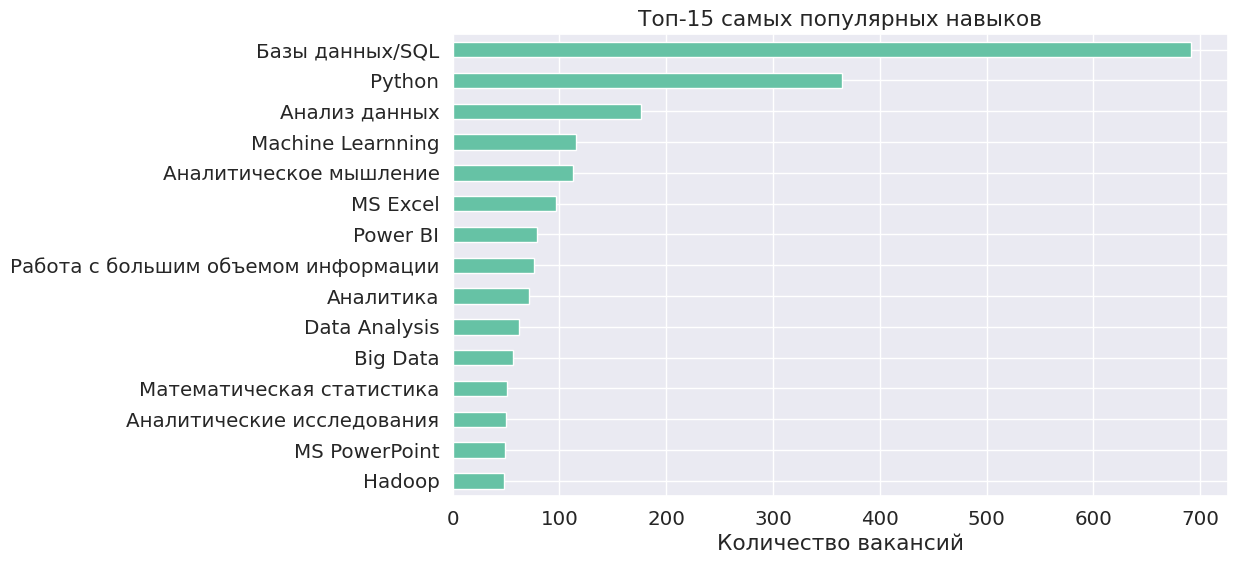

In [304]:
plt.figure(figsize=(10, 6))
skills.value_counts()[:15].sort_values().plot.barh()
plt.title("Топ-15 самых популярных навыков")
plt.xlabel("Количество вакансий");

**Вопрос 3.** Какую зарплату готовы платить работодатели? Соберите некоторым образом статистику и постройте гистограмму.

При работе с данными о заработной плате обратите внимание на валюту и <a target="_blank" href="https://yandex.ru/search/?text=gross%2Fnet&clid=1955455&win=446&lr=213&noreask=1">gross/net</a>. Постоянно подгружать курс валюты не требуется, достаточно фиксировать какой-то один более менее актуальный.

Будем считать минимальные зарплаты для каждой вакансии. Во-первых, вакансий, шде она указана, болше всех. Во-вторых, с точки зрения маркетинга, стоит рассчитвать на ту ЗП, которая указана как "От". Переведе все в рубли, учтем налоги, отбросим лишнее.

In [305]:
usd = 92
sals = pd.DataFrame(
    act_data, columns=["salary.from", "salary.to", "salary.currency", "salary.gross"]
)
sals = sals[sals["salary.from"].notna()].reset_index()
sals["min_sal_rub"] = (
    sals["salary.from"] - 0.13 * sals["salary.from"] * sals["salary.gross"]
)
sals["min_sal_rub"] = sals["min_sal_rub"] + sals["min_sal_rub"] * (usd - 1) * (
    sals["salary.currency"] == "USD"
)
sals

index  salary.from salary.to salary.currency salary.gross min_sal_rub
0        2     100000.0      None             RUR        False    100000.0
1        4      50000.0      None             RUR        False     50000.0
2       10     120000.0      None             RUR        False    120000.0
3       11     150000.0      None             RUR        False    150000.0
4       12      35000.0     50000             RUR        False     35000.0
..     ...          ...       ...             ...          ...         ...
245   1384      50000.0      None             RUR        False     50000.0
246   1394      80000.0    100000             RUR        False     80000.0
247   1400     150000.0      None             RUR         True    130500.0
248   1404     350000.0      None             RUR         True    304500.0
249   1406     150000.0      None             RUR        False    150000.0

[250 rows x 6 columns]

Построим гистограмму по минимальным зарплатам.

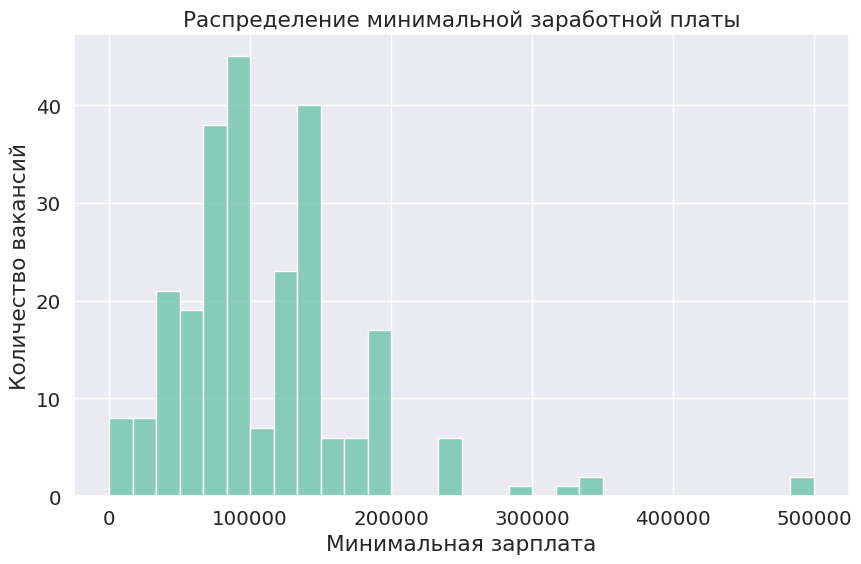

In [308]:
fig = plt.figure(figsize=(10, 6))
plot = sns.histplot(data=sals, x="salary.from", bins=30)
# plot.set_yscale("log")  # попробовал в логарифмической шкале, вышло не очень.
plot.set_xlabel("Минимальная зарплата")
plot.set_ylabel("Количество вакансий")
plot.set_title("Распределение минимальной заработной платы")
plt.show()

**Вопрос 4.** Какой формат работы предлагается (в офисе / удаленно / ...)?

In [309]:
act_data["schedule.name"].value_counts().sort_values()

schedule.name
Вахтовый метод         1
Сменный график         9
Гибкий график         45
Удаленная работа     259
Полный день         1099
Name: count, dtype: int64

Как видим, в основном предлагается полный рабочий день (видимо имеется в виду, что в офисе) - 80% и удаленная работа - 20%.
Но также, есть небольше кол-во вакансии с гибким графиком.

Проведите аналогичный анализ для наиболее привлекательной для вас профессии в любом регионе. Если это Data Scientist, то для анализа выберите другую. В данном пункте спокойно можно сделать копипасту кода.

Рассмотрим профессии связанные с финансами в Москве (логичнее рассматривать в Москве, чтобы, например, сравнить зарплаты и графики работы.

In [186]:
vacancy_url = "https://api.hh.ru/vacancies"
data_fin = pd.DataFrame()

for page in range(200):
    params = {
        "area": 1,
        "page": page,
        "per_page": 10,
        "text": '"Финансовый Аналитик" OR "финансовый" OR "Финансисит" OR "финансисит"',
    }

    request = requests.get(vacancy_url, params)
    page_data = json.loads(request.content.decode())

    page_df = pd.json_normalize(page_data["items"])
    data_fin = pd.concat([data_fin, page_df], ignore_index=True)
    sleep(0.5)

Удалим дубликаты

In [188]:
data_fin = data_fin.drop_duplicates("id")
data_fin = data_fin.dropna(how="all", axis=1)
data_fin

id  premium                                               name  \
0     95816441    False  Product & Process Implementation Technologist\...   
1     98304402    False                             Специалист по тендерам   
2     96555161    False                        Ассистент в отдел аналитики   
3     98560876    False                               Генеральный директор   
4     96621629    False  Чат менеджер / специалист чат-поддержки в язык...   
...        ...      ...                                                ...   
1995  96728446    False                       Директор по развитию бизнеса   
1996  97442124    False       Специалист сопровождения систем фискализации   
1997  97588359    False                                  Сборщица /сборщик   
1998  98559202    False        Заместитель финансового директора (УК ЗПИФ)   
1999  95041139    False                Управляющий объектом (эксплуатация)   

      has_test  response_letter_required              published_at  \
0        False                     False  2024-04-15T23:11:32+0300   
1        False                     False  2024-05-03T09:58:11+0300   
2        False                     False  2024-04-09T20:07:26+0300   
3        False                     False  2024-05-07T16:30:57+0300   
4        False                     False  2024-04-10T14:02:17+0300   
...        ...                       ...                       ...   
1995     False                     False  2024-04-11T15:33:49+0300   
1996     False                     False  2024-04-19T15:07:17+0300   
1997     False                     False  2024-05-07T09:10:28+0300   
1998     False                     False  2024-05-07T16:11:36+0300   
1999     False                     False  2024-05-06T15:30:14+0300   

                    created_at  archived  \
0     2024-04-15T23:11:32+0300     False   
1     2024-05-03T09:58:11+0300     False   
2     2024-04-09T20:07:26+0300     False   
3     2024-05-07T16:30:57+0300     False   
4     2024-04-10T14:02:17+0300     False   
...                        ...       ...   
1995  2024-04-11T15:33:49+0300     False   
1996  2024-04-19T15:07:17+0300     False   
1997  2024-05-07T09:10:28+0300     False   
1998  2024-05-07T16:11:36+0300     False   
1999  2024-05-06T15:30:14+0300     False   

                                    apply_alternate_url show_logo_in_search  \
0     https://hh.ru/applicant/vacancy_response?vacan...                None   
1     https://hh.ru/applicant/vacancy_response?vacan...                None   
2     https://hh.ru/applicant/vacancy_response?vacan...                None   
3     https://hh.ru/applicant/vacancy_response?vacan...                None   
4     https://hh.ru/applicant/vacancy_response?vacan...                 NaN   
...                                                 ...                 ...   
1995  https://hh.ru/applicant/vacancy_response?vacan...                None   
1996  https://hh.ru/applicant/vacancy_response?vacan...                None   
1997  https://hh.ru/applicant/vacancy_response?vacan...                True   
1998  https://hh.ru/applicant/vacancy_response?vacan...                None   
1999  https://hh.ru/applicant/vacancy_response?vacan...                 NaN   

      ... address.metro.station_name     address.metro.line_name  \
0     ...                        NaN                         NaN   
1     ...                        NaN                         NaN   
2     ...                        NaN                         NaN   
3     ...                        NaN                         NaN   
4     ...                        NaN                         NaN   
...   ...                        ...                         ...   
1995  ...                        NaN                         NaN   
1996  ...                 Пушкинская  Таганско-Краснопресненская   
1997  ...               Текстильщики  Таганско-Краснопресненская   
1998  ...                  Румянцево              Сокольническая   
1999  ..

Загрузим подробные описания.

In [ ]:
describtions_fin = pd.DataFrame()
for vac in data_fin["id"]:
    url = f"https://api.hh.ru/vacancies/{vac}"
    request = requests.get(url)
    describtion = json.loads(request.content.decode())
    page_describtion = pd.json_normalize(describtion)
    describtions_fin = pd.concat(
        [describtions_fin, page_describtion], ignore_index=True
    )
    sleep(0.5)

describtions_fin

Приведем таблицу к удобному виду и сохраним ее.

In [191]:
act_data_fin = pd.DataFrame(
    describtions_fin.dropna(how="all", axis=1),
    columns=[
        "id",
        "name",
        "description",
        "key_skills",
        "schedule.id",
        "schedule.name",
        "salary.from",
        "salary.to",
        "salary.currency",
        "salary.gross",
        "address.street",
        "address.building",
        "address.lat",
        "address.lng",
        "address.raw",
        "address.metro.station_name",
        "address.metro.line_name",
        "address.metro.station_id",
        "address.metro.line_id",
        "address.metro.lat",
        "address.metro.lng",
        "address.metro_stations",
    ],
)
act_data_fin = act_data_fin.dropna(how="all", axis=1)
act_data_fin.to_csv("vacancies_actual_fin.csv")
act_data_fin

id                                               name  \
0     95816441  Product & Process Implementation Technologist\...   
1     98304402                             Специалист по тендерам   
2     96555161                        Ассистент в отдел аналитики   
3     98560876                               Генеральный директор   
4     96621629  Чат менеджер / специалист чат-поддержки в язык...   
...        ...                                                ...   
1994  96728446                       Директор по развитию бизнеса   
1995  97442124       Специалист сопровождения систем фискализации   
1996  97588359                                  Сборщица /сборщик   
1997  98559202        Заместитель финансового директора (УК ЗПИФ)   
1998  95041139                Управляющий объектом (эксплуатация)   

                                            description  \
0     <p>На нашу фабрику кондитерских изделий в г Ст...   
1     <p>Молодая динамично развивающаяся компания <s...   
2     <p><strong>Мы находимся в поиске ассистента в ...   
3     <p><strong>АНО «Центр карьеры Роскосмоса» приг...   
4     <p>Мы молодая команда, которая основала школу-...   
...                                                 ...   
1994  <strong>Обязанности:</strong> <ul> <li>Разрабо...   
1995  <p><strong><em>ООО&quot;Автодор-Платные Дороги...   
1996  <p>Компания <strong>&quot;Научные развлечения&...   
1997  <p><strong>Обязанности:</strong></p> <p> </p> ...   
1998  <strong>Обязанности:</strong> <ul> <li>Организ...   

                                             key_skills schedule.id  \
0                                                    []     fullDay   
1     [{'name': 'Тендеры'}, {'name': 'Участие в Тенд...     fullDay   
2     [{'name': 'MS Excel'}, {'name': 'Ведение отчет...      remote   
3     [{'name': 'Стратегический менеджмент'}, {'name...     fullDay   
4     [{'name': 'Деловое общение'}, {'name': 'Делова...      remote   
...                                                 ...         ...   
1994                                                 []     fullDay   
1995                                                 []     fullDay   
1996  [{'name': 'Точность и внимательность к деталям...     fullDay   
1997                                                 []     fullDay   
1998                                                 []     fullDay   

         schedule.name  salary.from salary.to salary.currency salary.gross  \
0          Полный день          NaN       NaN             NaN          NaN   
1          Полный день     100000.0      None             RUR        False   
2     Удаленная работа     100000.0      None             RUR        False   
3          Полный день          NaN       NaN             NaN          NaN   
4     Удаленная работа          NaN     30000             RUR        False   
...                ...          ...       ...             ...          ...   
1994       Полный день          NaN    600000             RUR         True   
1995       Полный день     102000.0    122400             RUR         True   
1996       Полный день      55000.0     70000             RUR        False   
1997       Полный день          NaN    206000             RUR         True   
1998       Полный день          NaN       NaN             NaN          NaN   

      ... address.lat address.lng                         address.raw  \
0     ...         NaN         NaN                                 NaN   
1     ...   55.686736   37.440496        Москва, Очаковское шоссе, 34   
2     ...         NaN         NaN                                 NaN   
3     ...         NaN         NaN                                 NaN   
4     ...         NaN         NaN                                 NaN   
...   ...         ...         ...                                 ...   
1994  ...         NaN         NaN                                 NaN   
1995  ...   55.767610   37.608625        Москва, Страстной бульвар, 9   
1996  ...   55.705858   37.

**Полученную таблицу необходимо сохранить в формате xlsx и отправить боту вместе с решением.**

In [278]:
act_data_fin.to_excel("vacancies_actual_fin.xlsx")

**Вопрос 1.** Сколько сейчас доступно вакансий по вашему запросу?

In [195]:
print("Всего вакансий найдено:", act_data_fin.shape[0])

Всего вакансий найдено: 1999


**Вопрос 2.** Какие навыки чаще всего встречаются в вакансиях по данной специальности?

In [203]:
def extract_skill(list_of_dicts):
    for d in list_of_dicts:
        skills_fin.append(d["name"])


skills_fin = []
act_data_fin["key_skills"].apply(extract_skill)

# for i in range(len(skills)):
#     if "sql" in skills[i].lower() or ("баз" in skills[i].lower() and "данн" in skills[i].lower()):
#         skills[i] = "Базы данных/SQL"
#     if "ml" == skills[i].lower() or "машинное обучение" in skills[i].lower() or "machine learning" in skills[i].lower():
#         skills[i] = "Machine Learnning"

skills_fin = pd.Series(skills_fin)
skills_fin.shape

(10197,)

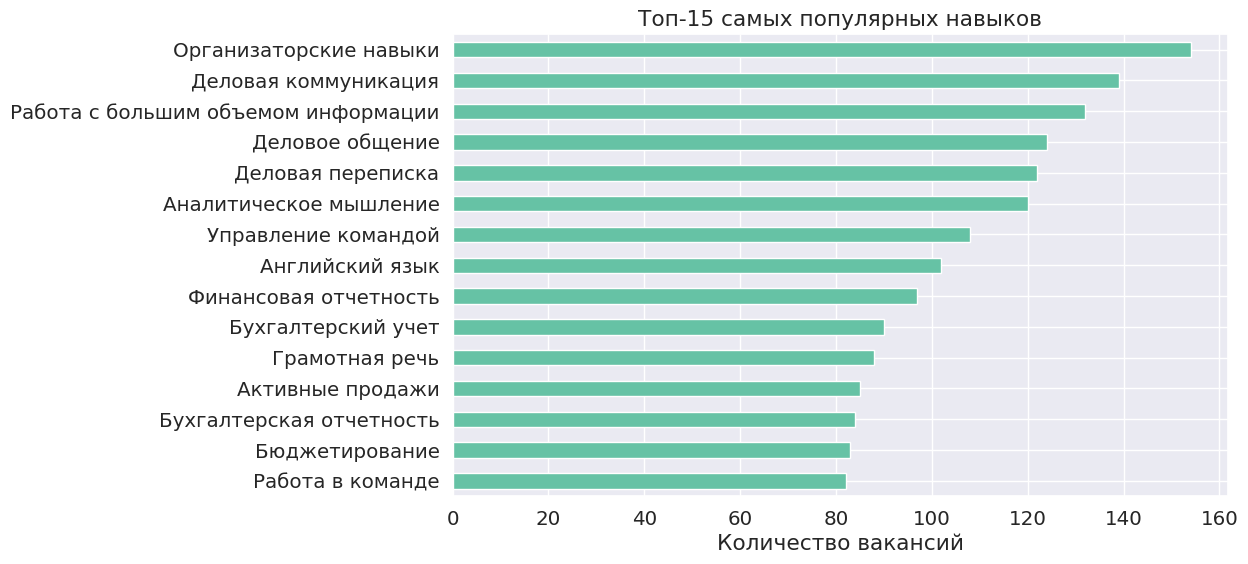

In [204]:
plt.figure(figsize=(10, 6))
skills_fin.value_counts()[:15].sort_values().plot.barh()
plt.title("Топ-15 самых популярных навыков")
plt.xlabel("Количество вакансий");

**Вопрос 3.** Какую зарплату готовы платить работодатели? Соберите некоторым образом статистику и постройте гистограмму.


In [259]:
usd = 92
eur = 99
sals_fin = pd.DataFrame(
    act_data_fin,
    columns=["salary.from", "salary.to", "salary.currency", "salary.gross"],
)
sals_fin = sals_fin[sals_fin["salary.from"].notna()].reset_index()
sals_fin["min_sal_rub"] = (
    sals_fin["salary.from"] - 0.13 * sals_fin["salary.from"] * sals_fin["salary.gross"]
)
sals_fin["min_sal_rub"] = (
    sals_fin["min_sal_rub"]
    + sals_fin["min_sal_rub"] * (usd - 1) * (sals_fin["salary.currency"] == "USD")
    + sals_fin["min_sal_rub"] * (eur - 1) * (sals_fin["salary.currency"] == "EUR")
)
sals_fin

index  salary.from salary.to salary.currency salary.gross min_sal_rub
0         1     100000.0      None             RUR        False    100000.0
1         2     100000.0      None             RUR        False    100000.0
2         5     270000.0      None             RUR         True    234900.0
3         8     600000.0      None             RUR        False    600000.0
4        13     180000.0    180000             RUR         True    156600.0
...     ...          ...       ...             ...          ...         ...
1087   1991      90000.0    140000             RUR        False     90000.0
1088   1992     150000.0    200000             RUR         True    130500.0
1089   1993     150000.0      None             RUR        False    150000.0
1090   1995     102000.0    122400             RUR         True     88740.0
1091   1996      55000.0     70000             RUR        False     55000.0

[1092 rows x 6 columns]

Визуализируем (уберем один выброс, который портит всю гисограмму)

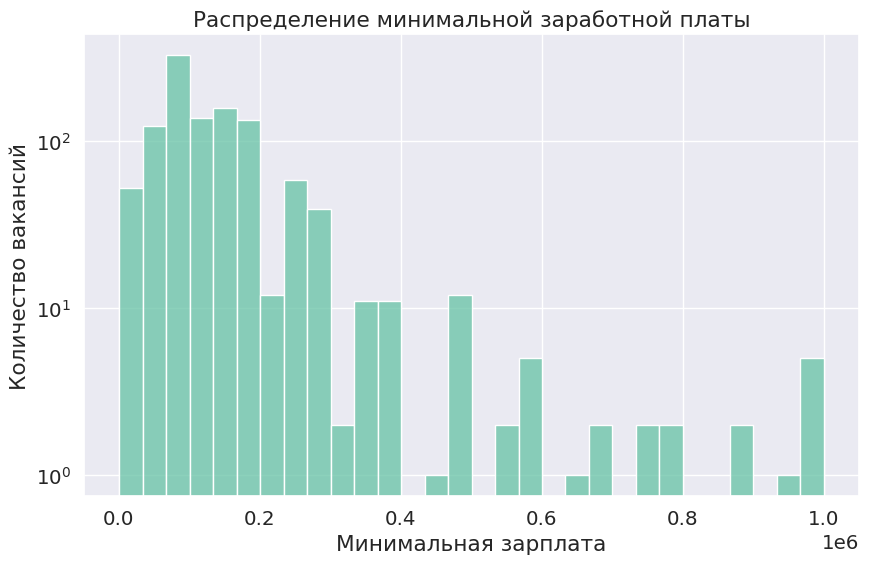

In [277]:
sals_fin = sals_fin[sals_fin["salary.from"] <= 1000005]

fig = plt.figure(figsize=(10, 6))
plot = sns.histplot(data=sals_fin, x="salary.from", bins=30)
plot.set_yscale("log")
plot.set_xlabel("Минимальная зарплата")
plot.set_ylabel("Количество вакансий")
plot.set_title("Распределение минимальной заработной платы")
plt.show()

**Вопрос 4.** Какой формат работы предлагается (в офисе / удаленно / ...)?

In [205]:
act_data_fin["schedule.name"].value_counts().sort_values()

schedule.name
Вахтовый метод         4
Гибкий график         50
Сменный график        59
Удаленная работа     376
Полный день         1510
Name: count, dtype: int64

Снова неиболее распространен полный рабочий день в офисе, но также есть много вариантов удаленной работы.

Не забывайте про выводы.

Итак, мы рассмотрели две профессии.
Аналитику данных стоит хорошо знать SQL, Python, Статистику, Машинное обучение, а также ииметь хорошее аналитическое мышление. В Москве он может спокойно зарабаотывать до пятисот тысяч в месяц чистыми. При этом работать придетс полный рабочий день (чаше всего).

Финансист же должен обладать организационными и комуникационными (как письменными, так и устными) навыками, а также уметь работать с данными и иметь аналитическое мышление и неплохой английский. При это зарплата его может доходить до миллиона рублей в месяц. Но здесь уже речь идет о директорских поициях и так далее.

В целом, зарплаты довольно похожи у двух этих направлений, так что стоит выбирать то, что больше нравится.


---

### <font color="green"><i>Факультативная часть</i></font>

---

### Задача 2.   

Для *одной* из рассмотренных ранее профессий исследуйте, в каком районе Москвы данная вакансия пользуется наибольшим и наименьшим спросом.
Не забудьте про визуализацию, в частности, постройте распределений вакансий на карте.

*Напоминание.* Работа в некоторой степени творческая, поэтому конкретные детали решения в основном остаются на усмотрение автора решения.


In [7]:
act_data = pd.read_csv("vacancies_actual.csv")
act_data

Unnamed: 0  index        id                                    name  \
0              0      0  98463457                   Data Analyst (junior)   
1              1      1  96170095                         Стажер-аналитик   
2              2      2  96555161             Ассистент в отдел аналитики   
3              3      3  98428661                         Аналитик данных   
4              4      4  97120695                              Стажер SAP   
...          ...    ...       ...                                     ...   
1408        1408   1434  96495389  Senior Data Scientist / ML разработчик   
1409        1409   1435  95899067    Data Scientist (команда Монетизации)   
1410        1410   1436  92696064        Data Scientist в b2c направление   
1411        1411   1437  96829016                         Аналитик данных   
1412        1412   1438  94604984         Data Scientist в Trust & Safety   

                                            description  \
0     <p><strong>Flowwow</strong> - маркетплейс, где...   
1     <p>Добрый день, наш будущий коллега!</p> <p>Fo...   
2     <p><strong>Мы находимся в поиске ассистента в ...   
3     <p><strong>MD.school — это онлайн-университет ...   
4     <p><strong>Обязанности:</strong></p> <ul> <li>...   
...                                                 ...   
1408  <p>GoodsForecast – российский вендор, аккредит...   
1409  Мы в Headhunter работаем с огромной клиентской...   
1410  <p>Наша команда работает с соискательской функ...   
1411  <p>Наша команда занимается созданием и развити...   
1412  <p>Каждый год все больше мошенников пытаются н...   

                                             key_skills schedule.id  \
0                                                    []      remote   
1                                                    []      remote   
2     [{'name': 'MS Excel'}, {'name': 'Ведение отчет...      remote   
3                                                    []      remote   
4                                                    []     fullDay   
...                                                 ...         ...   
1408  [{'name': 'Python'}, {'name': 'SQL'}, {'name':...     fullDay   
1409  [{'name': 'Python'}, {'name': 'Pandas'}, {'nam...    flexible   
1410  [{'name': 'Python'}, {'name': 'Machine Learnin...    flexible   
1411                                                 []     fullDay   
1412  [{'name': 'Python'}, {'name': 'Machine Learnin...    flexible   

         schedule.name  salary.from  salary.to  ... address.lat address.lng  \
0     Удаленная работа          NaN        NaN  ...         NaN         NaN   
1     Удаленная работа          NaN        NaN  ...   55.756807   37.622729   
2     Удаленная работа     100000.0        NaN  ...         NaN         NaN   
3     Удаленная работа          NaN        NaN  ...   55.755864   37.617698   
4          Полный день      50000.0        NaN  ...   55.683376   37.574112   
...                ...          ...        ...  ...         ...         ...   
1408       Полный день          NaN        NaN  ...         NaN         NaN   
1409     Гибкий график          NaN        NaN  ...   55.809343   37.628505   
1410     Гибкий график          NaN        NaN  ...   55.809343   37.628505   
1411       Полный день          NaN        NaN  ...         NaN         NaN   
1412     Гибкий график          NaN        NaN  ...   55.809343   37.628505   

                         address.raw address.metro.station_name  \
0                                NaN                        NaN   
1                             Москва          Площадь Революции   
2                                NaN                        NaN   
3                             Москва       Библиотека им.Ленина   
4          Москва, улица Кедрова, 15              Академическая   
...                              ...                        ...   
1408                             NaN                        NaN   
1409  Москва, улица Годовикова, 9с

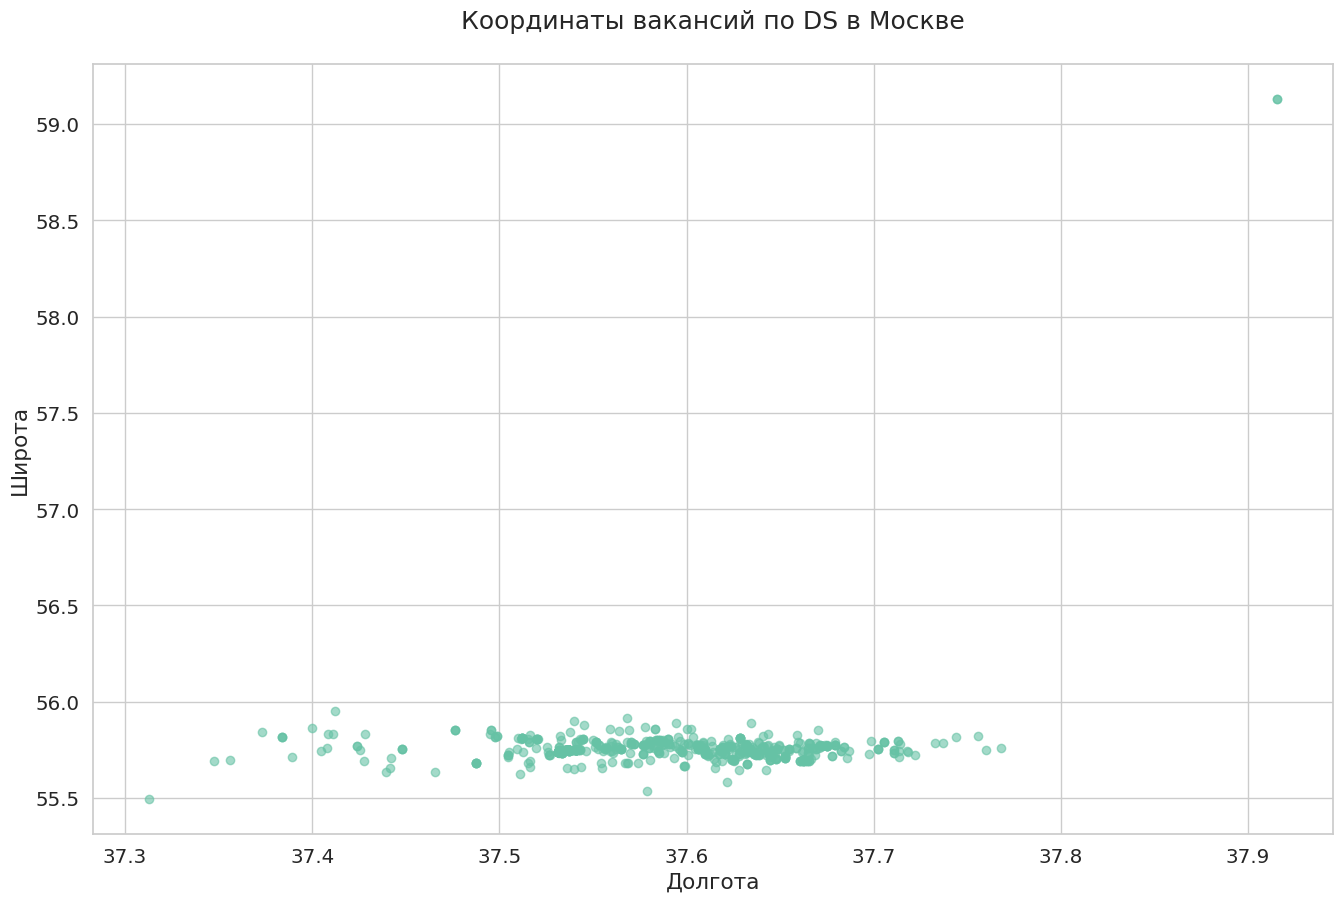

In [310]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(16, 10))
    plt.scatter(act_data["address.lng"], act_data["address.lat"], alpha=0.6)
    # plt.ylim([35.95, 36.35])
    # plt.xlim([-115.35, -115])

    plt.title("Координаты вакансий по DS в Москве\n", fontsize=18)
    plt.xlabel("Долгота")
    plt.ylabel("Широта")

Видим выброс. Удалим его и отобразим все вакансии на карте.

In [55]:
figure = px.scatter_mapbox(
    act_data[
        act_data["address.lng"].notna()
        & act_data["address.lat"].notna()
        & act_data["address.lat"]
        < 58.0
    ],
    lat="address.lat",
    lon="address.lng",
    center={"lat": 55.75, "lon": 37.62},
    zoom=10,
    opacity=0.9,
    mapbox_style="open-street-map",
)

plotly.offline.plot(figure, filename="moscow_ds.html", auto_open=False)

'moscow_ds.html'

Какие выводы можно сделать из построенных графиков?

Итак, распределение вакансий на карте показывает, что в целом вакансии распределены равномерно в радиусе до 10 км от Кремля. Тем не менее, можно выделить две точки - Деловой Центр и Технопарк, где вакансий больше, что логично. На расстоянии же больше 10 км от центра кол-во вакансий убывает с ростом радиуса.

---

### Задача 3.   

**1.** Проверьте, во скольких вакансиях среди выгруженных указана зарплата?


In [5]:
data = pd.read_csv("/kaggle/input/dataset10/vacancies_actual.csv")
data[data["salary.from"].notna() & data["salary.to"].notna()].shape, data[
    data["salary.from"].notna() | data["salary.to"].notna()
].shape, data[data["salary.from"].notna()].shape, data[data["salary.to"].notna()].shape

((105, 24), (300, 24), (250, 24), (155, 24))

**2.** Выполните кластеризацию вакансий, используя построенные эмбеддинги. Визуализируйте результаты и проинтерпретируйте кластеры.

Загружаем из huggingface обученную модель с соответствующим токенизатором <a target="_blank" href="https://huggingface.co/intfloat/multilingual-e5-small">intfloat/multilingual-e5-small</a> для получения эмбеддингов текста

In [3]:
!pip install -U sentence-transformers
import torch.nn.functional as F

import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer


def average_pool(last_hidden_states, attention_mask):
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-small")
model = AutoModel.from_pretrained("intfloat/multilingual-e5-small")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.5 MB/s eta 0:00:00a 0:00:01


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Предсказываем эмбеддинги описаний.

In [9]:
def make_embeddings(texts, model, tokenizer=None, batch_size=16):
    """
    Считает эмбеддинги текстов из массива texts

    :param texts: массив текстов
    :param model: модель для вычисления эмбеддингов
    :param tokenizer: токенизатор, соответствующий модели
    :param batch_size: размер батча при генерации эмбеддингов
    """
    text_embeddings = []

    for start_batch_idx in tqdm(range(0, len(texts), batch_size)):
        # Выбранная модель была обучена на входах, начинающихся с "query:" или "passage:".
        # Поэтому ко всем ответам надо добавить префикс "query:"
        input_texts = [
            "query: " + text
            for text in texts[start_batch_idx : start_batch_idx + batch_size]
        ]

        # Токенизируем тексты
        batch_dict = tokenizer(
            input_texts,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        # Применяем модель
        with torch.no_grad():
            outputs = model(**batch_dict)

        # Агрегируем выходы в эмбеддинги и нормализуем их
        embeddings = average_pool(
            outputs.last_hidden_state, batch_dict["attention_mask"]
        )
        embeddings = F.normalize(embeddings, p=2, dim=1)
        text_embeddings.append(embeddings)

    return torch.cat(text_embeddings).cpu().numpy()


data_embeddings = make_embeddings(
    data["description"], model=model, tokenizer=tokenizer, batch_size=16
)

0       <p><strong>Flowwow</strong> - маркетплейс, где...
1       <p>Добрый день, наш будущий коллега!</p> <p>Fo...
2       <p><strong>Мы находимся в поиске ассистента в ...
3       <p><strong>MD.school — это онлайн-университет ...
4       <p><strong>Обязанности:</strong></p> <ul> <li>...
                              ...                        
1408    <p>GoodsForecast – российский вендор, аккредит...
1409    Мы в Headhunter работаем с огромной клиентской...
1410    <p>Наша команда работает с соискательской функ...
1411    <p>Наша команда занимается созданием и развити...
1412    <p>Каждый год все больше мошенников пытаются н...
Name: description, Length: 1413, dtype: object

Теперь применяем k-means на полученных эмбеддингах, будем разбивать на 4 кластера.

In [10]:
# Делаем кластеризацию
kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
data_clusters = kmeans.fit_predict(data_embeddings)

Для визуализации полученных эмбеддингов спроецируем их на двумерное пространство с помощью PCA. Цветом покажем предсказанный кластер

In [13]:
# Делаем проекцию
pca = PCA(n_components=2)
data_projection = pca.fit_transform(data_embeddings)

# Интерактивная визуализация
fig = px.scatter(
    x=data_projection[:, 0],
    y=data_projection[:, 1],
    hover_name=data_clusters,
    hover_data={"description": data["description"]},
    color=data_clusters.astype(str),
    width=1000,
    height=800,
    title="PCA проекция эмбеддингов описаний вакансий на двумерное пространство",
    size=[1] * len(data),
    size_max=10,
)
plotly.offline.plot(fig, filename="clusters.html", auto_open=False)
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



График см в файле clusters.html

Для наглядности посмотрим на топ-5 типичных ответа для каждого кластера, где под типичностью имеется ввиду близость к центру масс.

In [17]:
cluster_names = [
    "Много ML/DL",
    "Непосредсвтенно Аналитика",
    "Маркетплейсы, маркетинговая аналитика - в общем, работа с клиентами",
    "Уклон в BigData и SWE",
]

for cluster in np.unique(data_clusters):
    cluster_points = data_projection[data_clusters == cluster]
    cluster_descriptions = data.loc[data_clusters == cluster, "description"]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем топ-5 уникальных ответов, соответствующих полученным индексам
    closest_descriptions = cluster_descriptions.iloc[closest_idxs].drop_duplicates()[:5]

    print(f"{cluster_names[cluster]}:")
    for i, ans in enumerate(closest_descriptions):
        print(f"    {i}. {ans}")
    print()

Много ML/DL:
    0. <p>В связи с расширением штата мы ищем коллегу на интересные проекты. В команде сейчас 6 специалистов: 4 DS, MLOps и тимлид.</p> <p><strong>Обязанности</strong></p> <ul> <li>анализ клиентской базы, построение ML моделей: сегментации, склонности к покупке/оттоку, прогноз LTV клиентов</li> <li>оптимизация процессов: антифрод модели</li> <li>создание и развитие рекомендательных систем</li> <li>коммуникация с бизнес заказчиками и формирование подхода к решению задач инструментами ML моделей (end2end разработка ML сервисов)</li> <li>построение предиктивных моделей, внедрение моделей в prod</li> <li>мониторинг эффективности, дообучение, корректировка моделей</li> </ul> <p><strong>Требования</strong></p> <ul> <li>владение SQL, Python и основными библиотеками анализа данных</li> <li>знания в направлениях Transformers, Auto-encoders, Recommender Systems.</li> <li>отличная математическая подготовка.</li> <li>умение объяснять сложные вещи простыми словами</li> <li>опыт работы 

Не забывайте про выводы.

Итак, получилась неплохая кластеризация с использованием модели intfloat/multilingual-e5-small. Полученные кластеры вполне отличимы друг от друга:
1. Много ML/DL
2. Непосредсвтенно Аналитика
3. Маркетплейсы, маркетинговая аналитика - в общем, работа с клиентами
4. Уклон в BigData и SWE
